In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pip install textblob

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import re
import plotly.express as px
import plotly.graph_objects as go

In [6]:
data = pd.read_excel('/content/drive/MyDrive/Elon_Tweets/twitter-elon-tesla- data.xlsx')
print(len(data))

34313


In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [8]:
data['post'] = data['post'].astype(str)

In [9]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [11]:
def clean_text(text):
  #Removeing the @ and url links before I tokenize
  text = re.sub(r'@\w+', '', text)
  text = re.sub(r'http\S+|www\S+', '', text)
  text = text.lower()
  #This section firstly tokenizes the words to feed into the model
  #It also removes useless stop words which do not provide any sentiment
  #And it lemmatizes/stems the words down to make it easier for the model to read
  tokens = word_tokenize(text)
  tokens = [word for word in tokens if not word.startswith('@') and not word.startswith('http')]
  tokens = [word for word in tokens if word.isalpha()]
  tokens = [word for word in tokens if word not in stop_words]
  tokens = [lemmatizer.lemmatize(word) for word in tokens]
  text = ' '.join(tokens)
  return text


In [12]:
data['cleaned_post'] = data['post'].apply(clean_text)

In [13]:
#Using a fairly simple blob model to get polarity for each transcript
#I could have also used the naives bayes analyser which would return a tuple for positive/negative value
def get_sentiment(text):
  analysis = TextBlob(text)
  return analysis.sentiment.polarity

data['sentiment_score'] = data['cleaned_post'].apply(get_sentiment)

In [14]:
#I have sorted the scores based on their continuous value into 3 discrete outcomes:
def categorize_sentiment(score):
  if score > 0:
    return 'Positive'
  elif score < 0:
    return 'Negative'
  else:
    return 'Neutral'

data['sentiment_category'] = data['sentiment_score'].apply(categorize_sentiment)

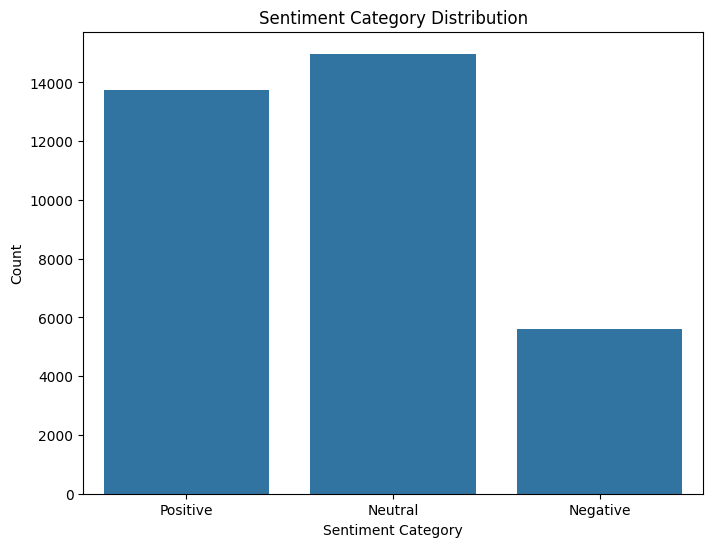

In [15]:
#Some visualisation on the number of positive negative and neutral outcomes to gauge sentiment for this time period
plt.figure(figsize=(8,6))
sns.countplot(x='sentiment_category',data=data,order = ['Positive','Neutral','Negative'])
plt.title('Sentiment Category Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

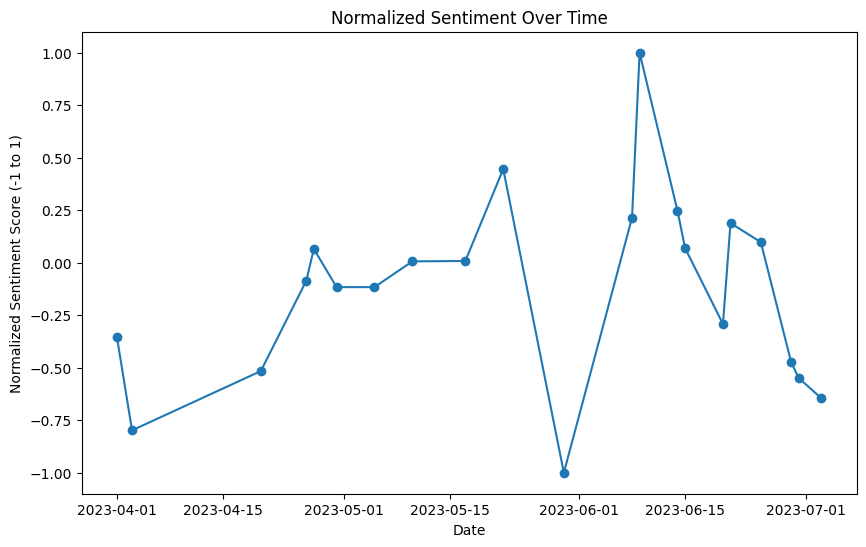

In [36]:
data['UTC Date'] = pd.to_datetime(data['UTC Date'])
sentiment_day = data.groupby(data['UTC Date'].dt.date)['sentiment_score'].mean()

min_val = sentiment_day.values.min()
max_val = sentiment_day.values.max()
normalized_values = 2 * (sentiment_day.values - min_val) / (max_val - min_val) - 1

plt.figure(figsize=(10, 6))
plt.plot(sentiment_day.index, normalized_values, marker='o', linestyle='-')
plt.title('Normalized Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Sentiment Score (-1 to 1)')
plt.show()

In [18]:
#Next ive created a nice visual to illustrate the count of the sentiment categories to give a visual understanding of the relative sizes on each day in the
data['UTC Date'] = pd.to_datetime(data['UTC Date'], errors='coerce').dt.date

sentiment_time = data.groupby(['UTC Date','sentiment_category']).size().reset_index()
sentiment_time.columns = ['Date','Sentiment Category','Count']

fig = px.bar(sentiment_time,x='Date',y='Count',color='Sentiment Category',title='Sentiment Over Time',color_discrete_map={'Positive':'green','Neutral':'blue','Negative':'red'})
fig.show()

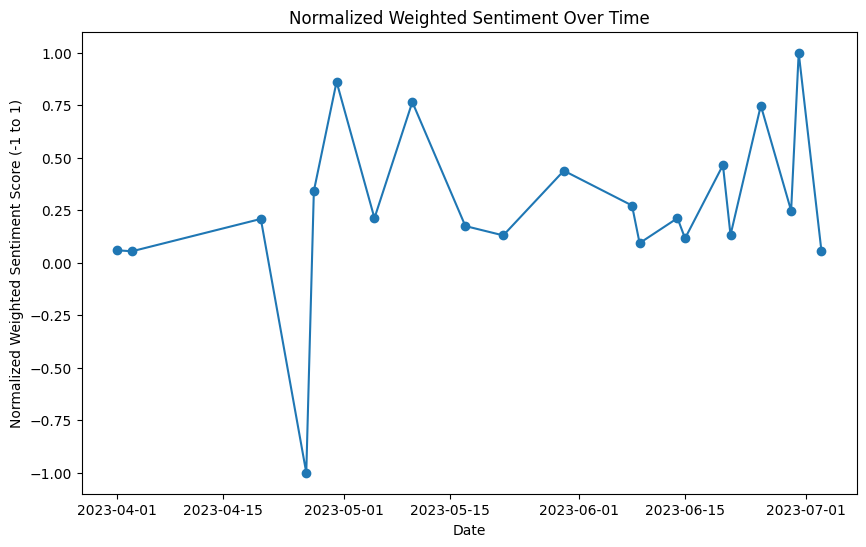

In [43]:
#Here is a better version of the sentiment graph that i showed earlier in that now we take the number of impressions into account
#This helps us understand the scale of the influence a particular positive negative or neutral comment may have
data['Weighted_Sentiment'] = data['sentiment_score'] * data['Impressions']

weighted_sentiment_by_date = data.groupby('UTC Date')['Weighted_Sentiment'].sum()

min_val = weighted_sentiment_by_date.values.min()
max_val = weighted_sentiment_by_date.values.max()
normalized_weighted_values = 2 * (weighted_sentiment_by_date.values - min_val) / (max_val - min_val) - 1

plt.figure(figsize=(10, 6))
plt.plot(weighted_sentiment_by_date.index, normalized_weighted_values, marker='o', linestyle='-')
plt.title('Normalized Weighted Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Weighted Sentiment Score (-1 to 1)')
plt.show()


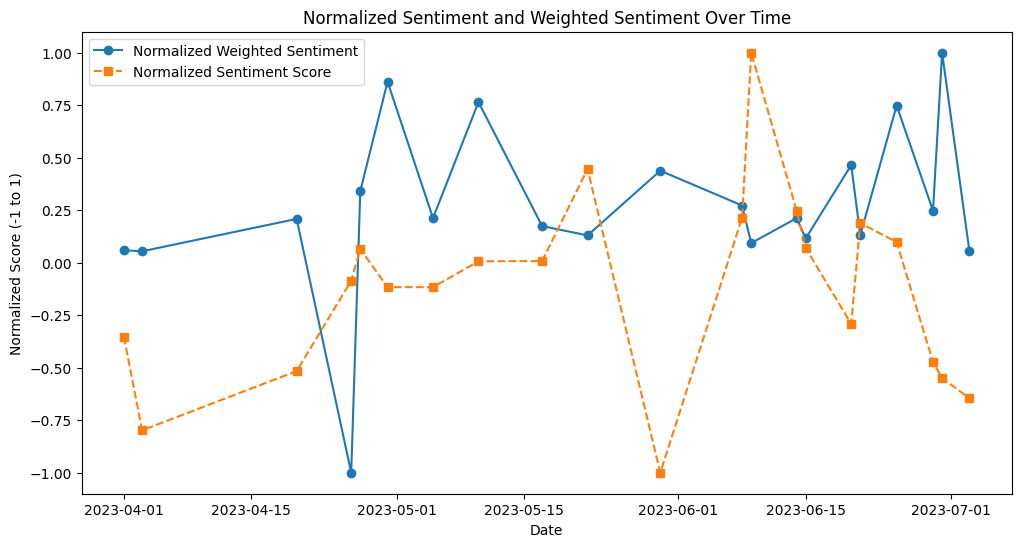

In [44]:
#Plot both the weighted and absolute sentiment on graphs to illustrate the difference there should be,
#This highlights how no matter how negative one particular tweeet may be, the exposure can be very different when taking into account impressions
plt.figure(figsize=(12, 6))
plt.plot(weighted_sentiment_by_date.index, normalized_weighted_values, marker='o', linestyle='-', label='Normalized Weighted Sentiment')
plt.plot(sentiment_day.index, normalized_sentiment, marker='s', linestyle='--', label='Normalized Sentiment Score')
plt.title('Normalized Sentiment and Weighted Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Normalized Score (-1 to 1)')
plt.legend()
plt.show()

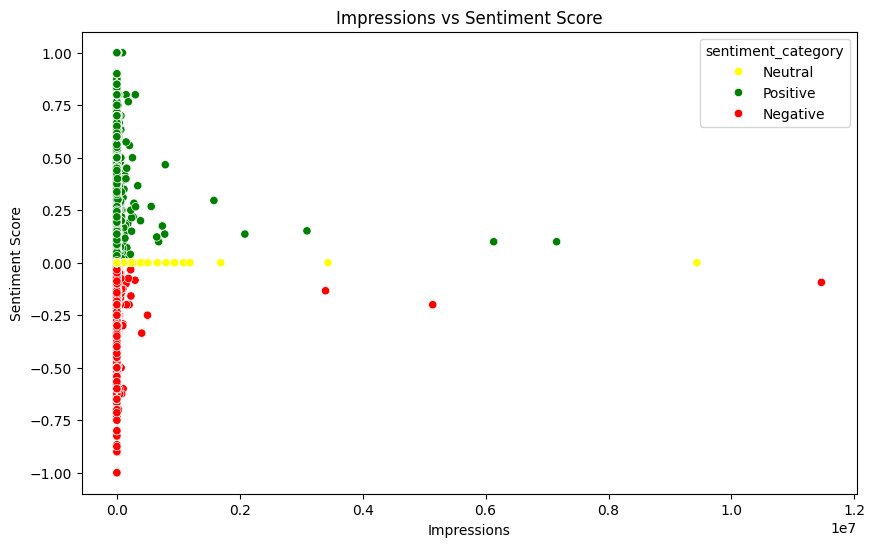

In [21]:
#Finally proves a visual correlation between the size of impressions and the sentiment category
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.scatterplot(x='Impressions', y='sentiment_score', data=data, hue='sentiment_category', palette={'Positive':'green','Neutral':'yellow','Negative':'red'})
plt.xlabel('Impressions')
plt.ylabel('Sentiment Score')
plt.title('Impressions vs Sentiment Score')
plt.show()